# 10. Hodnotenie videozáznamu

Doteraz sme sa zaoberali len dvojrozmernými obrazmi. V prípade videozáznamu má obrazová
funkcia tretí rozmer – čas. Spracovanie záznamu môže zabrať dlhší čas vzhľadom na veľký objem
dát. Aplikácie, ktoré majú takýto tok dát spracovať v reálnom čase musia byť obvykle
naprogramované veľmi efektívne. Pri videozázname máme výhodu, že spracovanie môže trvať (a
často trvá) dlhšie, ako samotný záznam.

In [1]:
import cv2, time, numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from skimage import draw
from IPython import display
from skimage import morphology
from IPython.display import Video
from skimage.color import rgb2gray
from skimage.measure import label, regionprops

plt.rc('font', **{'family' : 'DejaVu Sans', 'weight' : 'normal'})
plt.rcParams['font.size'] = 18

Statické kamery, ako v našom príklade, sú často využívané v bezpečnostných aplikáciách,
pri detekcii pohybu v scéne a pod. Načítajte videozáznam a prehrajte ho.

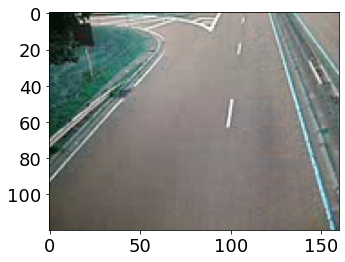

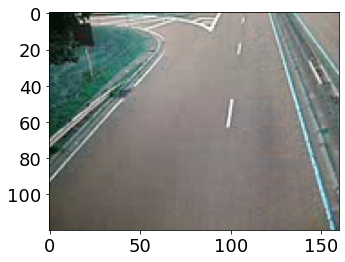

In [2]:
video_capture = cv2.VideoCapture('imgs/traffic.avi')

while video_capture.isOpened():
    _, frame = video_capture.read()
    if not frame is None:
        plt.imshow(frame)
        plt.draw()
        display.clear_output(wait= True)
        display.display(plt.gcf())
        time.sleep(.01)
    else:
        plt.draw()
        display.clear_output(wait= True)
        display.display(plt.gcf())
        time.sleep(.01)
        break

Prístup, ktorý využijeme je založený na analýze rozdielu medzi aktuálnou snímkou a pozadím.
Body objektov, ktoré na pozadí neboli budú mať v matici rozdielu nenulovú hodnotu – zápornú,
ak sú svetlejšie, ako pozadie a kladnú ak sú tmavšie. V našom prípade budeme považovať pozadie za statické.
Nie je to síce bežné, nakoľko aj objekty pozadia sú obvykle v pohybe – konáre a listy sa hýbu vo vetre a pod.,
ale v tomto príklade nebudeme potrebovať modelovať pozadie zložitejším spôsobom.
Prvá snímka videa bude našou referenčnou snímkou predstavujúcou pozadie, t.j. prázdnu vozovku.
Pre demonštráciu segmentácie vozidiel použijeme snímku č. 67.

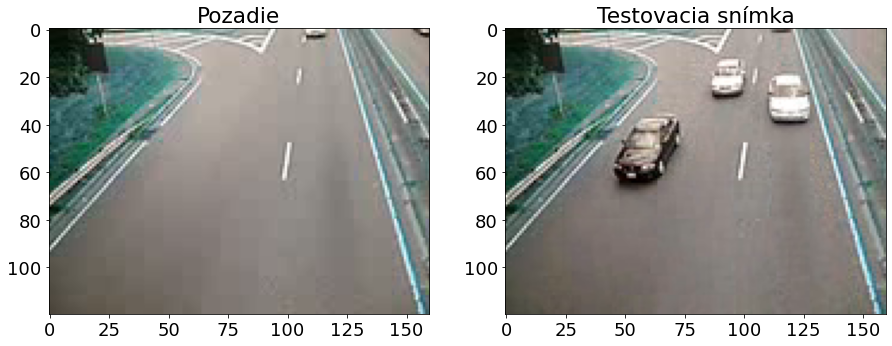

In [3]:
width  = int(video_capture.get(cv2.CAP_PROP_FRAME_HEIGHT))
height = int(video_capture.get(cv2.CAP_PROP_FRAME_WIDTH))
length = int(video_capture.get(cv2.CAP_PROP_FRAME_COUNT))
fps = int(video_capture.get(cv2.CAP_PROP_FPS))

video_capture.set(cv2.CAP_PROP_POS_FRAMES,0)
_, background_image = video_capture.read()

video_capture.set(cv2.CAP_PROP_POS_FRAMES, 67)
_, image_with_cars = video_capture.read()

plt.figure(figsize= (15,10))
plt.subplot(121)
plt.title("Pozadie")
plt.imshow(background_image)

plt.subplot(122)
plt.title("Testovacia snímka")
plt.imshow(image_with_cars);

Vypočítame rozdiel aktuálnej snímky od pozadia. Absolútnu hodnotu rozdielu prahujeme.
Použijeme pomerne vysoký prah, nakoľko pozadie nie je celkom statické a expozícia snímok sa
počas záznamu mení.

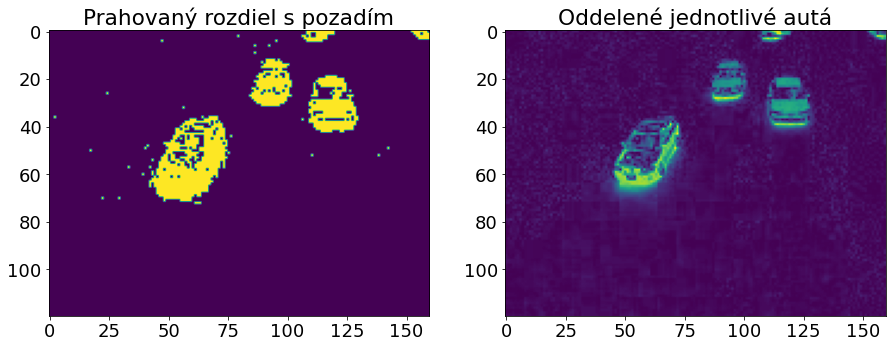

In [4]:
diff_image = np.abs(rgb2gray(background_image) - rgb2gray(image_with_cars))
diff_thresholded = diff_image*255 > 20

plt.figure(figsize= (15, 10))
plt.subplot(121)
plt.title("Prahovaný rozdiel s pozadím")
plt.imshow(diff_thresholded)

plt.subplot(122)
plt.title("Oddelené jednotlivé autá")
plt.imshow(diff_image);

Po odčítaní pozadia vystúpia vozidlá aj ich tiene. Morfologickými operáciami sa pokúsime
odstrániť šum, autá „vyplniť“ aby sme dostali spojité objekty, zodpovedajúce jednotlivým
vozidlám. Je podstatné, aby každé auto reprezentoval len jeden spojitý objekt, inak algoritmus
identifikuje v scéne viac áut, ako tam naozaj je. Uzavretím vyplníme objekty, otvorením sa zbavíme malých fragmentov, ktoré sú
súčasťou jedného vozidla. Týmto odstránime falošne pozitívne detekované autá.

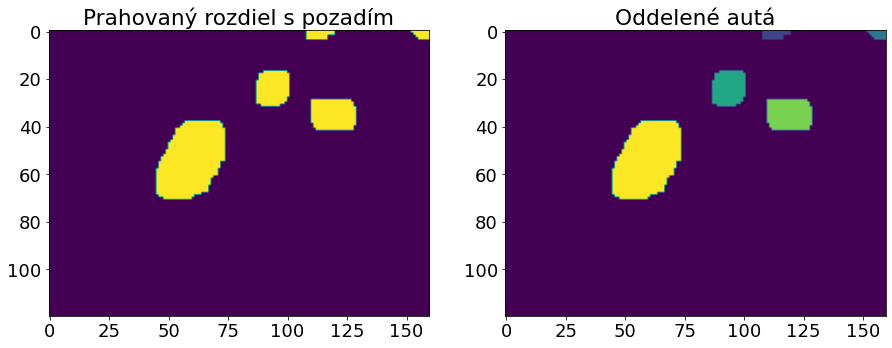

In [5]:
diff_thresholded = morphology.opening(
                    morphology.remove_small_holes(
                        diff_thresholded, area_threshold=64),
                            selem = morphology.selem.rectangle(8, 8))

plt.figure(figsize= (15, 10))
plt.subplot(121)
plt.title("Prahovaný rozdiel s pozadím")
plt.imshow(diff_thresholded)

plt.subplot(122)
plt.title("Oddelené autá")
label_img = label(diff_thresholded)     #jednotlivé objekty "olabelujeme"
plt.imshow(label_img);

Ďalším krokom je určenie ťažísk jednotlivých objektov na obrázku. Ťažisko neskôr zvýrazníme. Na
určenie ťažiska použijeme funkciu *regionprops*, ktorá počíta rôzne vlastnosti objektov (plocha,
poloha ťažiska, polomer a pod.). Nás zaujíma ťažisko, t.j. *centroid*. Jednotlivé položky poľa _regions_
obsahujú súradnice ťažísk (reálne hodnoty). Spojíme ich do jednej matice. Potom v cykle
prechádzame všetky ťažiská a zvýrazňujeme ich v obrázku modrou. Pri hľadaní pixelu zodpovedajúcemu
ťažisku použijeme zaokrúhľovanie nadol a zvýrazníme aj jeho susedov.

<Figure size 1080x720 with 0 Axes>

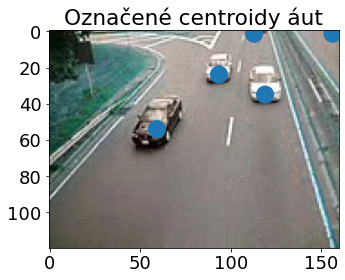

In [6]:
plt.figure(figsize= (15, 10))
fig, ax = plt.subplots(1)
ax.set_title("Označené centroidy áut")
ax.imshow(image_with_cars)
regions = regionprops(label_img)
for region in regions:
    centroid_viz = patches.Circle((region.centroid[1], region.centroid[0]))
    ax.add_patch(centroid_viz)

Teraz rovnakým spôsobom upravíme všetky snímky videa. Na zápis výsledku úprav vytvoríme
štvorrozmernú maticu *tagged_cars*, ktorá bude dátovým typom zodpovedať RGB obrázku.
4 rozmery sú použité aby sme zabezpečili jednoduchý prístupu k RGB zložkám jednotlivých
snímok. Ak by sme pracovali so šedotónovým videom vystačili by sme s trojrozmernou maticou.

In [7]:
video_capture = cv2.VideoCapture('imgs/traffic.avi')
video_capture.set(cv2.CAP_PROP_POS_FRAMES, 0)
_, background_image = video_capture.read()

colors = [[255, 0, 0], [0, 255, 0], [0, 0, 255], [100, 0, 200]]
color_id = 0

trajectories = []
fourcc = cv2.VideoWriter_fourcc(*'XVID')
tagged_cars = cv2.VideoWriter('imgs/tagged_cars.avi', fourcc, fps, (height, width))

while(video_capture.isOpened()):
    ret, frame = video_capture.read()
    if ret==True:
        diff_image = np.abs(rgb2gray(background_image) - rgb2gray(frame))   #detekcia objektov
        diff_thresholded = diff_image*255 > 20  #parhovanie objektov
        diff_thresholded[0:15, :] = 0    #morfologicke operácie
        diff_thresholded = morphology.opening(
                                morphology.remove_small_holes(
                                    diff_thresholded,area_threshold=64),
                                        selem=morphology.selem.rectangle(8,8))

        label_img = label(diff_thresholded)
        regions = regionprops(label_img)

        stats, trajectories_new = [], []    #vytvorenie zoznamu centroidov z regiónov v danej snímke
        for region in regions:
            stats.append(region.centroid)

        #tvorba trajektórií
        for centroid in stats:
            if len(trajectories) == 0:  #vlozime začiatok trajektórie a inicializujeme farby
                trajectories_new.append([color_id, [centroid]])
                color_id += 1
                if color_id > 3 :
                    color_id = 0
            else:   #pre druhy frame zistime farby suseda a pokračujeme v tvorbe trajektórií
                dists = []
                for trajectory in trajectories:
                    dists.append(np.linalg.norm(np.array(trajectory[1][-1][0],
                                                         trajectory[1][-1][1]) - np.array(centroid[0], centroid[1])))
                min_dist, min_dist_idx = dists[np.argmin(dists)], np.argmin(dists)
                if min_dist < 10:
                    color = trajectories[min_dist_idx][0]
                    trajectory = trajectories[min_dist_idx][1]
                    trajectory.append(centroid)
                    trajectories_new.append([color, trajectory])
                else:
                    trajectories_new.append([color_id, [centroid]])
                    color_id += 1
                    if color_id > 3 :
                        color_id = 0

        trajectories = trajectories_new     #novy zoznam trajektórií
        if len(trajectories) != 0 : #nastavenie farieb
            for x in trajectories:
                color = x[0]
                trajectory = x[1]

                for coords in trajectory:
                    rr, cc = draw.disk((coords[0], coords[1]), 1)
                    frame[rr, cc, 0] = colors[color][0]
                    frame[rr, cc, 1] = colors[color][1]
                    frame[rr, cc, 2] = colors[color][2]
        tagged_cars.write(frame)
    else:
        break

print("Finished!")
video_capture.release()
tagged_cars.release()

Finished!


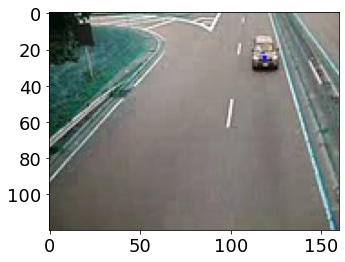

In [ ]:
video_capture = cv2.VideoCapture('imgs/tagged_cars.avi')

while video_capture.isOpened():
    _, frame = video_capture.read()
    if not frame is None:
        plt.imshow(frame)
        plt.draw()
        display.clear_output(wait= True)
        display.display(plt.gcf())
        time.sleep(.01)
    else:
        plt.draw()
        display.clear_output(wait= True)
        display.display(plt.gcf())
        time.sleep(.01)
        break

# Úloha

Pomocou odhadu dĺžky jednotlivých jazdných pruhov, porovnaním s dĺžkou vozidiel vypočítajte
priemernú rýchlosť jednotlivých áut pri prechode scénou a spočítajte vozidlá, ktoré scénou prešli.